In [29]:
from PIL import Image
import os, glob, numpy as np
from sklearn.model_selection import train_test_split

caltech_dir = "./crowling_img"
categories = ['말티즈', '푸들', '시베리안허스키', '시츄']
nb_classes = len(categories)

image_w = 32

image_h = 32

pixels = image_h * image_w*3

X = []
y = []

for idx, cat in enumerate(categories):
    
    #one-hot 돌리기.
    label = [0 for i in range(nb_classes)]
    label[idx] = 1

    image_dir = caltech_dir + "/" + cat
    files = glob.glob(image_dir+"/*.jpg")
    print(cat, " 파일 길이 : ", len(files))
    
    
    for i, f in enumerate(files):
        img = Image.open(f)
        img = img.convert("RGB")
        img = img.resize((image_w, image_h))
        data = np.asarray(img)
        X.append(data)
        y.append(label)


X = np.array(X)
y = np.array(y)

X_train, X_test, y_train, y_test = train_test_split(X, y)

xy = (X_train, X_test, y_train, y_test)
np.save("./numpy_data/multi_image_data5.npy", xy)
print("ok", len(y))


말티즈  파일 길이 :  158
푸들  파일 길이 :  99
시베리안허스키  파일 길이 :  124
시츄  파일 길이 :  130
ok 511


이제 numpy 데이터를 불러온다. 저것을 가지고 학습!

In [30]:
import os, glob, numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
import matplotlib.pyplot as plt
import keras.backend.tensorflow_backend as K
import cv2
import tensorflow as tf
# config = tf.compat.v1.ConfigProto()
# config.gpu_options.allow_growth = True
# session = tf.compat.v1.Session(config=config)

X_train, X_test, y_train, y_test = np.load('./numpy_data/multi_image_data5.npy', allow_pickle=True)



print(X_train.shape[1:])


(32, 32, 3)


In [31]:
categories = ['말티즈', '푸들', '시베리안허스키', '시츄']
nb_classes = len(categories)

#일반화

X_train = X_train.astype(float) / 255
X_test = X_test.astype(float) / 255



In [32]:
# 학습 전용 데이터 수 늘리기 --- (*1)
x_new = []
y_new = []
for i, xi in enumerate(X_train):
    yi = y_train[i]
    for ang in range(-30, 60, 5):
        # 회전 시키기 --- (*2)
        center = (16, 16) # 회전 중심
        mtx = cv2.getRotationMatrix2D(center, ang, 1.0)
        xi2 = cv2.warpAffine(xi, mtx, (32, 32))
        x_new.append(xi2)
        y_new.append(yi)
        # 좌우 반전 --- (*3)
        xi3 = cv2.flip(xi2, 1)
        x_new.append(xi3)
        y_new.append(yi)

# 이미지를 늘린 데이터를 학습 데이터로 사용하기
print('수량을 늘리기 전=', len(y_train))
X_train = np.array(x_new)
y_train = np.array(y_new)
print('수량을 늘린 후=', len(y_train))

#X_train = X_train.reshape(X_train.shape[0], 32,32,1).astype('float32')
#X_test = X_test.reshape(X_test.shape[0], 32,32,1).astype('float32')

print(X_train)

수량을 늘리기 전= 383
수량을 늘린 후= 13788
[[[[0.000 0.000 0.000]
   [0.000 0.000 0.000]
   [0.000 0.000 0.000]
   ...
   [0.000 0.000 0.000]
   [0.000 0.000 0.000]
   [0.000 0.000 0.000]]

  [[0.000 0.000 0.000]
   [0.000 0.000 0.000]
   [0.000 0.000 0.000]
   ...
   [0.000 0.000 0.000]
   [0.000 0.000 0.000]
   [0.000 0.000 0.000]]

  [[0.000 0.000 0.000]
   [0.000 0.000 0.000]
   [0.000 0.000 0.000]
   ...
   [0.000 0.000 0.000]
   [0.000 0.000 0.000]
   [0.000 0.000 0.000]]

  ...

  [[0.000 0.000 0.000]
   [0.000 0.000 0.000]
   [0.000 0.000 0.000]
   ...
   [0.000 0.000 0.000]
   [0.000 0.000 0.000]
   [0.000 0.000 0.000]]

  [[0.000 0.000 0.000]
   [0.000 0.000 0.000]
   [0.000 0.000 0.000]
   ...
   [0.000 0.000 0.000]
   [0.000 0.000 0.000]
   [0.000 0.000 0.000]]

  [[0.000 0.000 0.000]
   [0.000 0.000 0.000]
   [0.000 0.000 0.000]
   ...
   [0.000 0.000 0.000]
   [0.000 0.000 0.000]
   [0.000 0.000 0.000]]]


 [[[0.000 0.000 0.000]
   [0.000 0.000 0.000]
   [0.000 0.000 0.000]
   ...
  

In [33]:

model = Sequential()
model.add(Conv2D(32, (3,3), padding="same", input_shape=X_train.shape[1:], activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))
    
model.add(Conv2D(64, (3,3), padding="same", activation='relu'))
model.add(Conv2D(64, (3,3), padding="same", activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))
    
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(nb_classes, activation='softmax'))



model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_dir = './model'
    
if not os.path.exists(model_dir):
    os.mkdir(model_dir)
    
model_path = './model/dogBreedModel4.hdf5'
checkpoint = ModelCheckpoint(filepath=model_path , monitor='val_loss', verbose=1, save_best_only=True)
early_stopping = EarlyStopping(monitor='val_loss', patience=10)
tensor_board=TensorBoard(log_dir='./logs')

    

In [34]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 16, 16, 64)        18496     
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 16, 16, 64)        36928     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 8, 8, 64)          0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 8, 8, 64)         

In [35]:

history = model.fit(X_train, y_train, batch_size=32, epochs=20, validation_data=(X_test, y_test), callbacks=[checkpoint, early_stopping])

Train on 13788 samples, validate on 128 samples
Epoch 1/20
13728/13788 [============================>.] - ETA: 0s - loss: 0.6835 - accuracy: 0.7165
Epoch 00001: val_loss improved from inf to 0.58370, saving model to ./model/dogBreedModel4.hdf5
13788/13788 [==============================] - 17s 1ms/sample - loss: 0.6826 - accuracy: 0.7169 - val_loss: 0.5837 - val_accuracy: 0.7969
Epoch 2/20
13760/13788 [============================>.] - ETA: 0s - loss: 0.3238 - accuracy: 0.8801
Epoch 00002: val_loss improved from 0.58370 to 0.48927, saving model to ./model/dogBreedModel4.hdf5
13788/13788 [==============================] - 16s 1ms/sample - loss: 0.3236 - accuracy: 0.8802 - val_loss: 0.4893 - val_accuracy: 0.8750
Epoch 3/20
13728/13788 [============================>.] - ETA: 0s - loss: 0.1885 - accuracy: 0.9313
Epoch 00003: val_loss did not improve from 0.48927
13788/13788 [==============================] - 15s 1ms/sample - loss: 0.1882 - accuracy: 0.9314 - val_loss: 0.6048 - val_accuracy

In [36]:
print("정확도 : %.4f" % (model.evaluate(X_test, y_test)[1]))

128/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

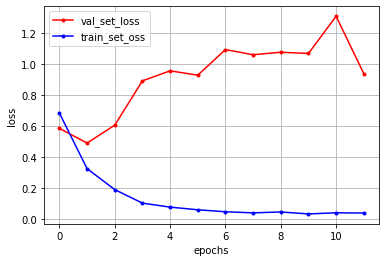

In [37]:
y_vloss = history.history['val_loss']
y_loss = history.history['loss']

x_len = np.arange(len(y_loss))

plt.plot(x_len, y_vloss, marker='.', c='red', label='val_set_loss')
plt.plot(x_len, y_loss, marker='.', c='blue', label='train_set_oss')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('loss')
plt.grid()
plt.show()

In [38]:
from PIL import Image
import os, glob, numpy as np
from keras.models import load_model

In [2]:
import tensorflow as tf
from PIL import Image
import os, glob, numpy as np
from keras.models import load_model
import keras

caltech_dir = "./testImg"
image_w = 32
image_h = 32

pixels = image_h * image_w * 3

X = []
filenames = []
files = glob.glob(caltech_dir+"/*.*")
for i, f in enumerate(files):   
    test_img = Image.open(f)  
    test_img = test_img.convert("RGB") 
    test_img = test_img.resize((image_w, image_h))  
    data = np.asarray(test_img)/255   
    filenames.append(f)
    X.append(data)   
X = np.array(X)

model = tf.keras.models.load_model('./model/dogBreedModel4.hdf5')
prediction = model.predict(X)
np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})
cnt = 0
print('prediction', prediction, 'Finished prediction')
#['말티즈', '푸들', '불독', '시베리안허스키', '시츄']
#이 비교는 그냥 파일들이 있으면 해당 파일과 비교. 카테고리와 함께 비교해서 진행하는 것은 _4 파일.
for i in prediction:
    pre_ans = i.argmax()  # 예측 레이블
    #print(i)

    pre_ans_str = ''
    if pre_ans == 0: pre_ans_str = "말티즈"
    elif pre_ans == 1: pre_ans_str = "푸들"
    elif pre_ans == 2: pre_ans_str = "시베리안허스키"
    elif pre_ans == 3: pre_ans_str = "시츄"

    else: pre_ans_str = "모름"
    if i[0] >= 0.08: print("해당 "+filenames[cnt].split("\\")[1]+"이미지는 "+pre_ans_str+"로 추정됩니다.")
    if i[1] >= 0.08: print("해당 "+filenames[cnt].split("\\")[1]+"이미지는 "+pre_ans_str+"으로 추정됩니다.")
    if i[2] >= 0.08: print("해당 "+filenames[cnt].split("\\")[1]+"이미지는 "+pre_ans_str+"로 추정됩니다.")
    if i[3] >= 0.08: print("해당 "+filenames[cnt].split("\\")[1]+"이미지는 "+pre_ans_str+"로 추정됩니다.")

    cnt += 1
    # print(i.argmax()) #얘가 레이블 [1. 0. 0.] 이런식으로 되어 있는 것을 숫자로 바꿔주는 것.
    # 즉 얘랑, 나중에 카테고리 데이터 불러와서 카테고리랑 비교를 해서 같으면 맞는거고, 아니면 틀린거로 취급하면 된다.
    # 이걸 한 것은 _4.py에.


prediction [[1.000 0.000 0.000 0.000]
 [0.994 0.000 0.002 0.003]
 [0.007 0.001 0.573 0.418]
 [0.000 1.000 0.000 0.000]
 [0.998 0.001 0.001 0.000]
 [0.215 0.000 0.015 0.770]
 [0.000 0.000 0.161 0.839]
 [0.000 0.000 0.000 1.000]] Finished prediction
해당 maltize2.jpg이미지는 말티즈로 추정됩니다.
해당 maltize3.jpg이미지는 말티즈로 추정됩니다.
해당 martiz.jpg이미지는 시베리안허스키로 추정됩니다.
해당 martiz.jpg이미지는 시베리안허스키로 추정됩니다.
해당 puddle.jpg이미지는 푸들으로 추정됩니다.
해당 puddle2.jpg이미지는 말티즈로 추정됩니다.
해당 sichu.PNG이미지는 시츄로 추정됩니다.
해당 sichu.PNG이미지는 시츄로 추정됩니다.
해당 sichu2.jpg이미지는 시츄로 추정됩니다.
해당 sichu2.jpg이미지는 시츄로 추정됩니다.
해당 sichu3.jpg이미지는 시츄로 추정됩니다.


비록 데이터가 적지만 그래도 나름 학습이 잘 되었습니다.

하지만 **validation data와 test data가 나뉘어져 있지 않습니다.**

이는 매우 위험한 시도입니다. 왜냐하면 검증 단계에서 테스트 데이터를 사용했는데 또 마지막에 정확도 검출 시 test_data를 사용합니다.

데이터가 충분하다면 이런짓은 하지 않는게 좋습니다!

하지만 새로운 데이터에 대한 예측은 그래도 잘 하는군요!